In [46]:
import gym
env = gym.make("Taxi-v3").env

In [12]:
print("Action Space {}".format(env.action_space))

Action Space Discrete(6)


What are the actions the agent can choose from at each step?


0 drive down

1 drive up

2 drive right

3 drive left

4 pick up a passenger

5 drop off a passenger

In [4]:
print("State Space {}".format(env.observation_space))

State Space Discrete(500)


And the states?

 - 25 possible taxi positions, because the world is a 5x5 grid.

 - 5 possible locations of the passenger, which are R, G, Y, B, plus the case when the passenger is in the taxi.

 - 4 destination locations

Which gives us 25 x 5 x 4 = 500 states

What about rewards?

 - -1 default per-step reward.
Why -1, and not simply 0? Because we want to encourage the agent to spend the shortest time, by penalizing each extra step. This is what you expect from a taxi driver, don’t you?

 - +20 reward for delivering the passenger to the correct destination.

 - -10 reward for executing a pickup or dropoff at the wrong location.

You can read the rewards and the environment transitions (state, action ) → next_state from env.P.

In [2]:
# env.P is double dictionary.
# - The 1st key represents the state, from 0 to 499
# - The 2nd key represens the action taken by the agent,
#   from 0 to 5

# example
state = 123
action = 0  # move south

# env.P[state][action][0] is a list with 4 elements
# (probability, next_state, reward, done)
# 
#  - probability
#    It is always 1 in this environment, which means
#    there are no external/random factors that determine the
#    next_state
#    apart from the agent's action a.
#
#  - next_state: 223 in this case
# 
#  - reward: -1 in this case
#
#  - done: boolean (True/False) indicates wheter the
#    episode has ended (i.e. the driver has dropped the
#    passenger at the correct destination)

print('env.P[state][action][0]: ', env.P[state][action][0])

env.P[state][action][0]:  (1.0, 223, -1, False)


By the way, you can render the environment under each state to double-check this env.P vectors make sense:

From `state=123`

In [47]:
# Need to call reset() at least once before render() will work
env.env.reset()
print(env.s)

env.env.s = 123

print(env.s)

env.render(mode='human')

183
123
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



the agent moves south `action=0` to get to `state=223`


In [45]:
env.env.s = 223
env.render(mode='human')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## BASELINE

Before you start implementing any complex algorithm, you should always build a baseline model.

This advice applies not only to Reinforcement Learning problems but Machine Learning problems in general.

It is very tempting to jump straight into the complex/fancy algorithms, but unless you are really experienced, you will fail terribly.

Let’s use a random agent as a baseline model.

In [48]:
class RandomAgent:
    """
    This taxi driver selects actions randomly.
    You better not get into this taxi!
    """
    def __init__(self, env):
        self.env = env.env

    def get_action(self, state) -> int:
        """
        We have `state` as an input to keep
        a consistent API for all our agents, but it
        is not used.
        
        i.e. The agent does not consider the state of
        the environment when deciding what to do next.
        This is why we call it "random".
        """
        return self.env.action_space.sample()

agent = RandomAgent(env)

In [49]:
# set initial state of the environment
env.env.reset()
state = 123
env.env.s = state

epochs = 0
penalties = 0  # wrong pick up or dropp off
reward = 0

# store frames to latter plot them
frames = []

done = False

while not done:
    
    action = agent.get_action(state)
    
    state, reward, done, info = env.env.step(action)

    if reward == -10:
        penalties += 1
    
    frames.append({
        'frame': env.env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 2755
Penalties incurred: 952


In [50]:
# view how our random agent did

from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        sleep(0.2)
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(0.3)

print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Timestep: 34
State: 163
Action: 2
Reward: -1


KeyboardInterrupt: 

To get a more representative measure of performance, we can repeat the same evaluation loop `n=100times` starting each time at a random state.


In [53]:
from tqdm import tqdm

n_episodes = 100

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []

for i in tqdm(range(0, n_episodes)):
    
    # reset environment to a random state
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        action = agent.get_action(state)       
        next_state, reward, done, info = env.step(action) 
               
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
    
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


If you plot `timesteps_per_episode` and `penalties_per_episode` you can observe that none of them decreases as the agent completes more episodes. In other words, the agent is NOT LEARNING anything.

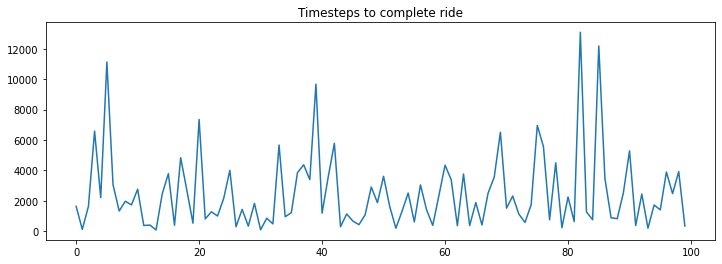

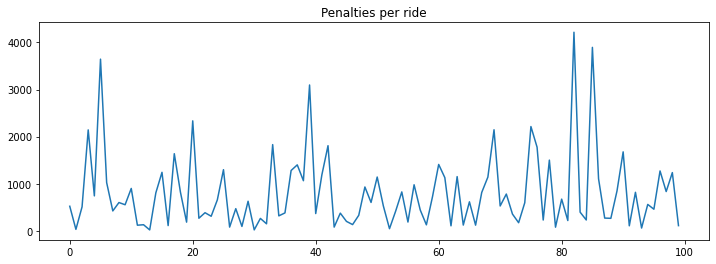

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")    
pd.Series(timesteps_per_episode).plot(kind="line")
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")    
pd.Series(penalties_per_episode).plot(kind="line")
plt.show()